In [ ]:
import re
import pandas as pd
import os
os.makedirs("saved", exist_ok=True)

def extract_experiments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    experiments = []
    current_experiment = {}
    accuracies = []
    epsilon_line = False
    if 'inf' in file_path or 'gap' in file_path:
        starts = "the value of hops"
    else:
        starts = "the value of epsilon"
    
    for line in lines:
        if epsilon_line:
            epsilon_line = False
            current_experiment['epsilon'] = float(line.strip())
        if line.startswith(starts):
            if current_experiment:  # Save the previous experiment if exists
                current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
                experiments.append(current_experiment)
                accuracies = []
            
            current_experiment = {}
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()
        
        if any(keyword in line for keyword in ["the value of beta", "the value of alpha_1", "the bound_lipschitz"]):
            params = line.strip().split(" ; ")
            for param in params:
                key, value = param.split(" is ")
                current_experiment[key.strip().split(" ")[-1]] = value.strip()

        if 'gap' in file_path and any(keyword in line for keyword in ["epsilon:"]):
            params = line.strip().split(":")
            epsilon_line = True
        
        accuracy_match = re.search(r'test/acc\s+(\d+\.\d+)', line)
        if accuracy_match:
            accuracies.append(float(accuracy_match.group(1)))
    
    if current_experiment:  # Save the last experiment
        current_experiment['max_accuracy'] = max(accuracies) if accuracies else None
        experiments.append(current_experiment)
    
    return experiments

# extract_experiments("caribou_chains2_inf.txt")

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
def get_caribou_results(group="hops", group2='epsilon', dataset='chains', exp_num=1, k='all', dpi=100, font_size=30, y_tick_interval=10, title_pad=10):
    experiments = []
    gap_experiments = []
    for i in range(7):
        if i == 6:
            file_path = f'output_eps_hop/caribou_{dataset}{exp_num}_inf.txt'
        else:
            file_path = f'output_eps_hop/caribou_{dataset}{exp_num}_e{2**i}.txt'
        experiments += extract_experiments(file_path)
    experiments_df = pd.DataFrame(experiments)
    experiments_df[group] = pd.to_numeric(experiments_df[group], errors='coerce')
    experiments_df[group2] = pd.to_numeric(experiments_df[group2], errors='coerce')
    experiments_df[group].fillna(-1, inplace=True)
    experiments_df[group2].fillna(-1, inplace=True)
    experiments_df['max_accuracy'] = pd.to_numeric(experiments_df['max_accuracy'], errors='coerce')
    experiments_df.sort_values(by=[group, group2], inplace=True)

    gap_experiments += extract_experiments(f'output_eps_hop/gap_{dataset}{exp_num}_inf.txt')
    gap_experiments += extract_experiments(f'output_eps_hop/gap_{dataset}{exp_num}_e.txt')


    gap_experiments_df = pd.DataFrame(gap_experiments)
    gap_experiments_df[group] = pd.to_numeric(gap_experiments_df[group], errors='coerce')
    gap_experiments_df[group2] = pd.to_numeric(gap_experiments_df[group2], errors='coerce')
    gap_experiments_df[group].fillna(-1, inplace=True)
    gap_experiments_df[group2].fillna(-1, inplace=True)
    gap_experiments_df['max_accuracy'] = pd.to_numeric(gap_experiments_df['max_accuracy'], errors='coerce')
    gap_experiments_df.sort_values(by=[group, group2], inplace=True)

    # print(experiments_df, gap_experiments_df)
    for key in pd.unique(experiments_df[group2]):
        # print(key)
        
        plot_df = experiments_df[experiments_df[group2] == key]
        plot_gap_df = gap_experiments_df[gap_experiments_df[group2] == key]

        if k != 'all':
            plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
        plot_df.to_csv(f'saved/caribou_{dataset}{exp_num}_{group}_{group2}_{key}_top_{k}_acc.csv', index=False)
        print(f'Data used for the plot are saved to saved/caribou_{dataset}{exp_num}_{group}_{group2}_{key}_top_{k}_acc.csv')
        plot_gap_df.to_csv(f'saved/gap_{dataset}{exp_num}_{group}_{group2}_{key}_top_{k}_acc.csv', index=False)
        plt.figure(dpi=dpi)
        # plt.rc('font', size=font_size)
        plt.rcParams['font.size'] = font_size
        plt.plot(range(len(plot_gap_df[group])), plot_gap_df['max_accuracy'], marker='o', linestyle='-',label='gap')
        
        # Create box plots
        # max_y = max(np.max(plot_df['max_accuracy'].to_list()), np.max(plot_gap_df['max_accuracy'].to_list()))
        # min_y = min(np.min(plot_df['max_accuracy'].to_list()), np.min(plot_gap_df['max_accuracy'].to_list()))
        max_y = 100
        # print(experiments_df['max_accuracy'].to_list())
        # print(gap_experiments_df['max_accuracy'].to_list())
        # print(np.min(experiments_df['max_accuracy'].to_list()), np.min(gap_experiments_df['max_accuracy'].to_list()))
        min_y = min(np.nan_to_num(np.min(experiments_df['max_accuracy'].to_list()), nan=100), 
                np.nan_to_num(np.min(gap_experiments_df['max_accuracy'].to_list()), nan=100))
        min_y=40
        # print(min_y)
        min_y = np.floor(min_y / y_tick_interval) * y_tick_interval
        max_y = np.ceil(max_y / y_tick_interval) * y_tick_interval
        plot_df = plot_df.replace(-1, 'inf')
        plot_df[group] = plot_df[group].apply(lambda x: int(x) if isinstance(x, float) else x)
        sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')
        # plt.xlabel(group)
        plt.ylabel('Accuracy')
        plt.ylim(min_y, max_y + 2)
        plt.yticks(np.arange(min_y, max_y + 1, y_tick_interval))
        plt.tight_layout()
        # plt.margins(x=0.01)
        if key == -1:
            key = 'inf'
        # if k == 'all':
        #     plt.title(f'caribou_{dataset}{exp_num} accuracies {group2}={key}', pad=title_pad)
        # else:
        #     plt.title(f'caribou_{dataset}{exp_num} top {k} accuracies {group2}={key}', pad=title_pad)
        plt.tight_layout()
        plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # plt.grid(visible=True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        # plt.yticks(np.arange(min_y, max_y + 1, 10))
        if key == 'inf':
            group_label = 'inf'
        else:
            if group2 == 'epsilon':
                group_label = f'e{int(key)}'
            elif group2 == 'hops':
                group_label = f'hops{int(key)}'
        if group == 'epsilon':
            plt.xlabel('$\epsilon$')
        elif group == 'hops':
            plt.xlabel('$K$')
        if group2 == 'epsilon':
            save_label = 'eps'
        elif group2 == 'hops':
            save_label = 'K'
        os.makedirs(f"../../AE_outputs/CRV/{save_label}", exist_ok=True)
        save_name = f'../../AE_outputs/CRV/{save_label}/acc5_{dataset}{exp_num}_{group_label}.png'
        plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)
        # plt.figsize = (5, 6)
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0.03)
        plt.show()
        # plt.savefig('margin.png', bbox_inches='tight')


In [16]:
exp_num = 1
k = 5
get_caribou_results('hops', 'epsilon', 'chains', exp_num, k, dpi=100, font_size=24)
get_caribou_results('epsilon', 'hops', 'chains', exp_num, k, dpi=100, font_size=24)

/tmp/ipykernel_1084565/221220161.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/221220161.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

OSError: Cannot save file into a non-existent directory: 'saved'

/tmp/ipykernel_1084565/221220161.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/221220161.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_-1.0_top_5_acc.csv


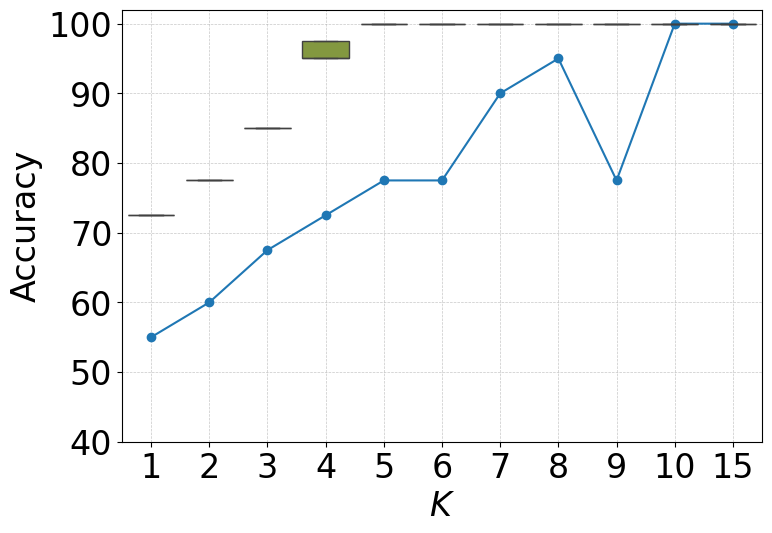

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_1.0_top_5_acc.csv


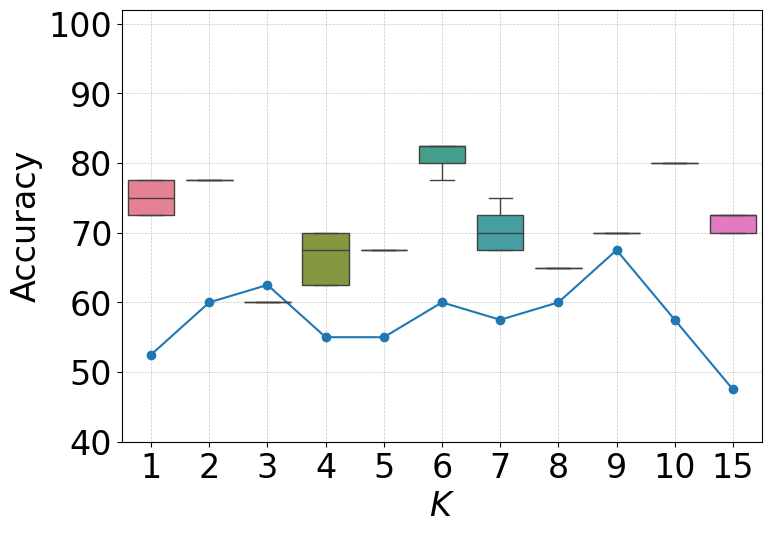

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_2.0_top_5_acc.csv


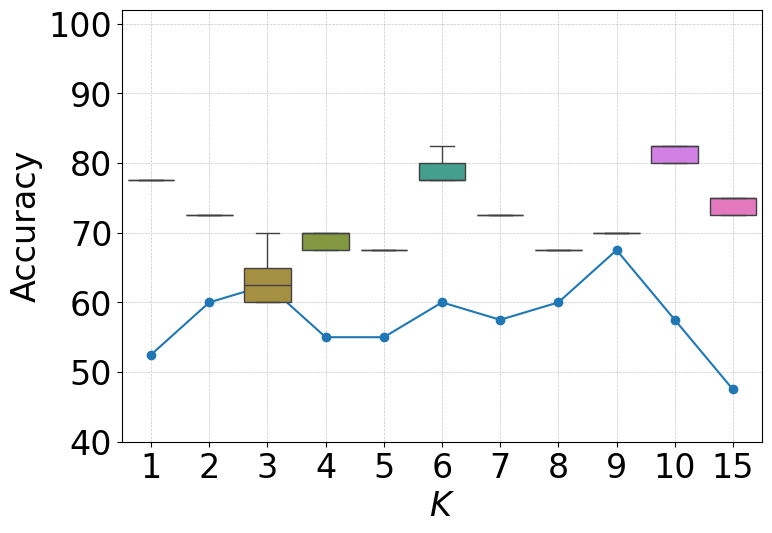

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_4.0_top_5_acc.csv


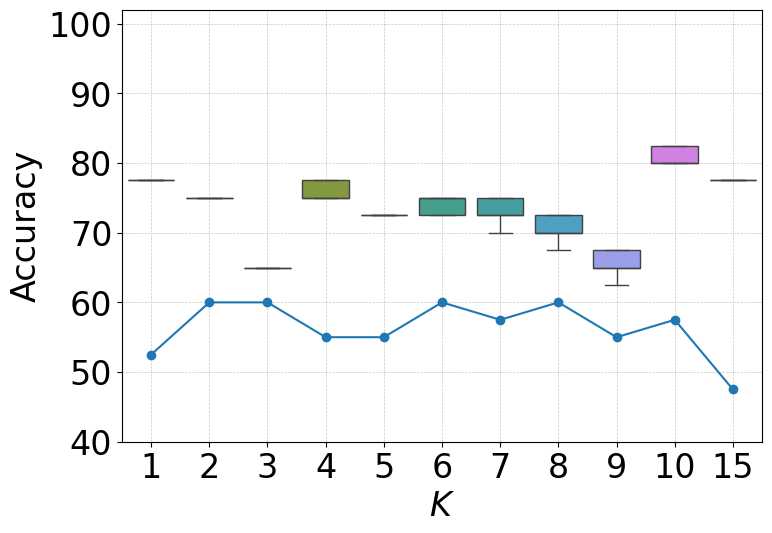

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_8.0_top_5_acc.csv


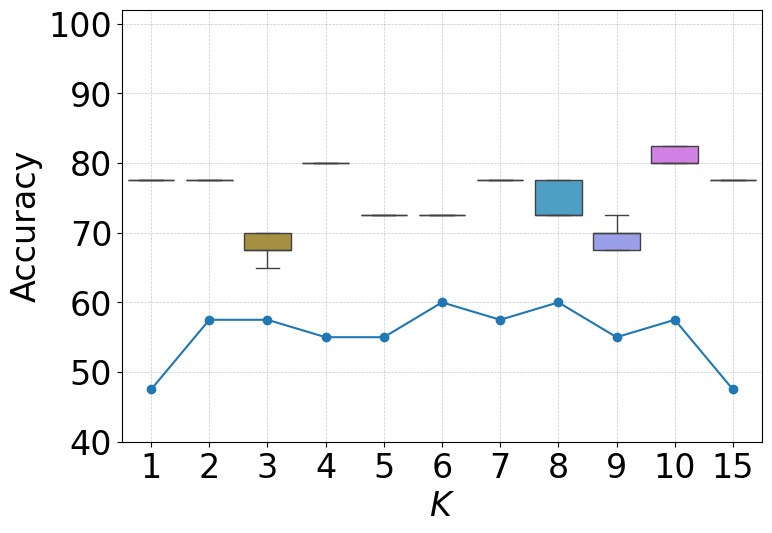

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_16.0_top_5_acc.csv


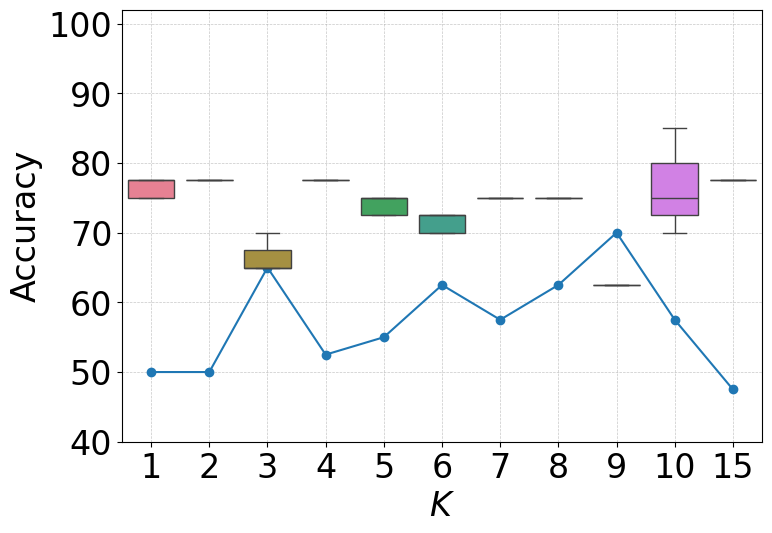

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_hops_epsilon_32.0_top_5_acc.csv


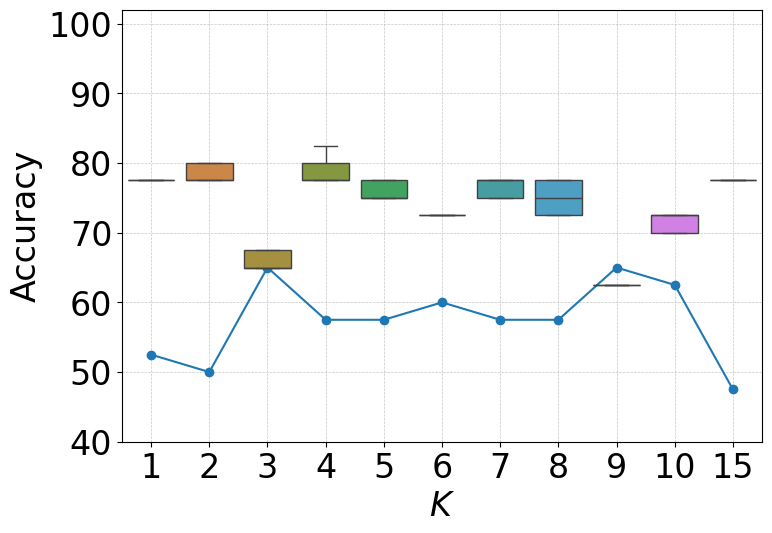

/tmp/ipykernel_1084565/221220161.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/221220161.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_1_top_5_acc.csv


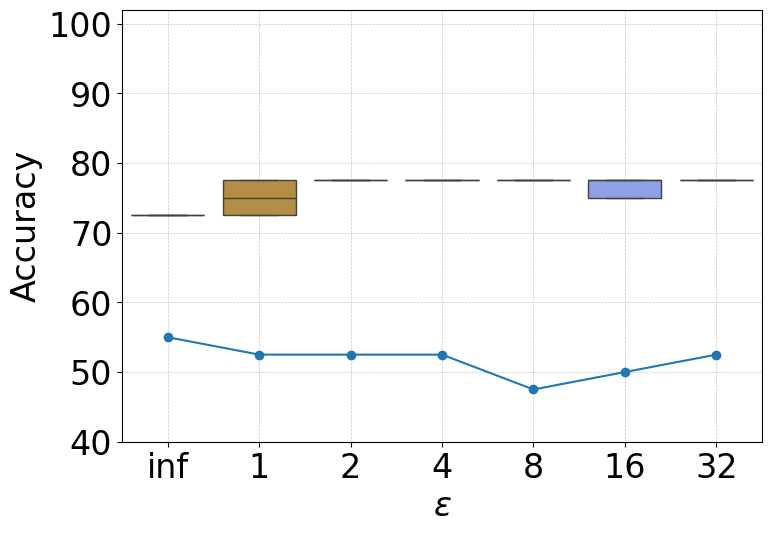

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_2_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


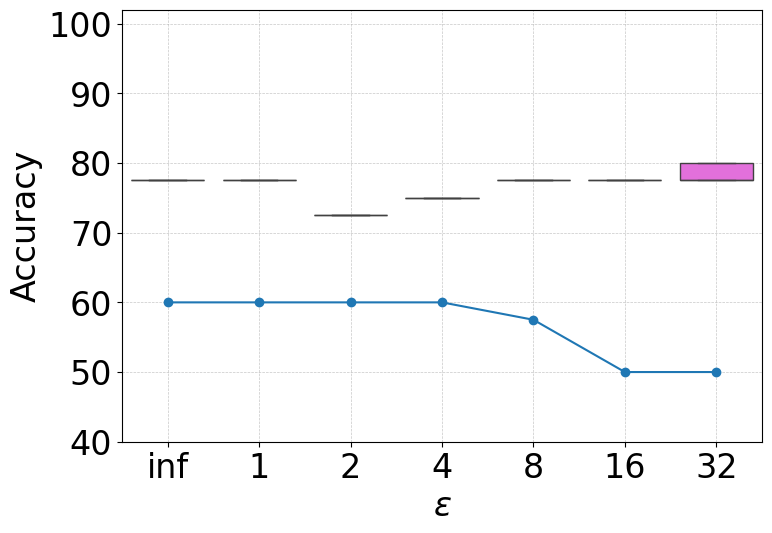

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_3_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


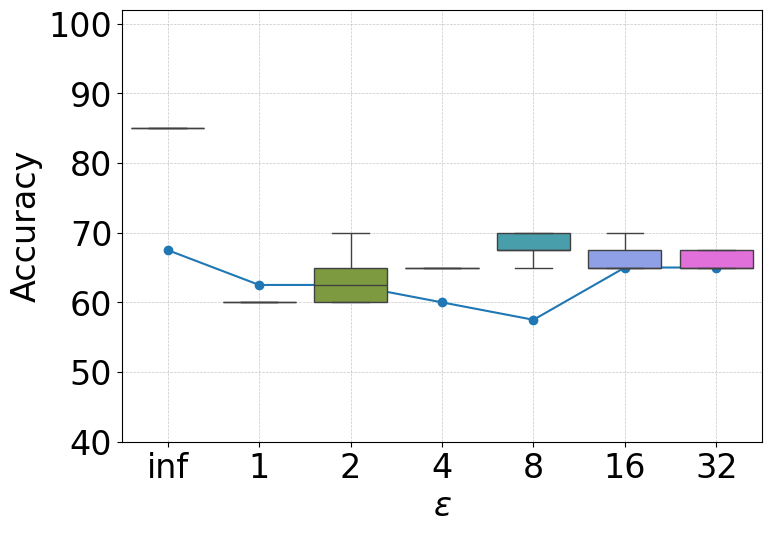

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_4_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


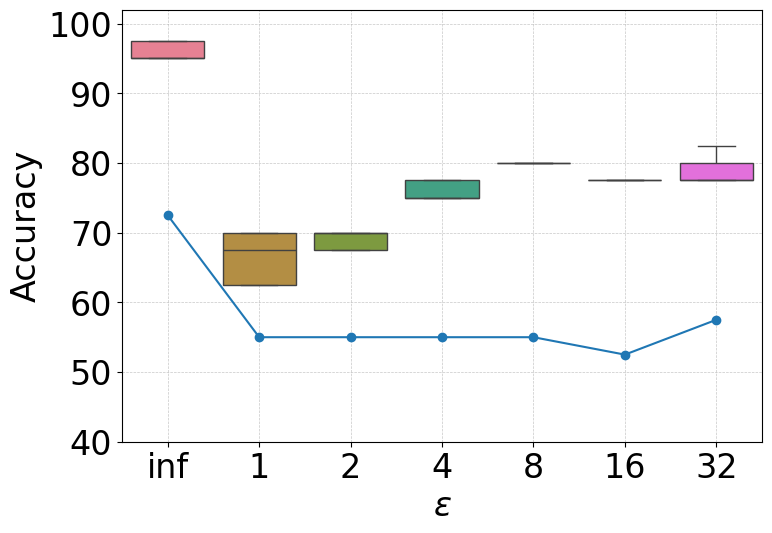

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_5_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


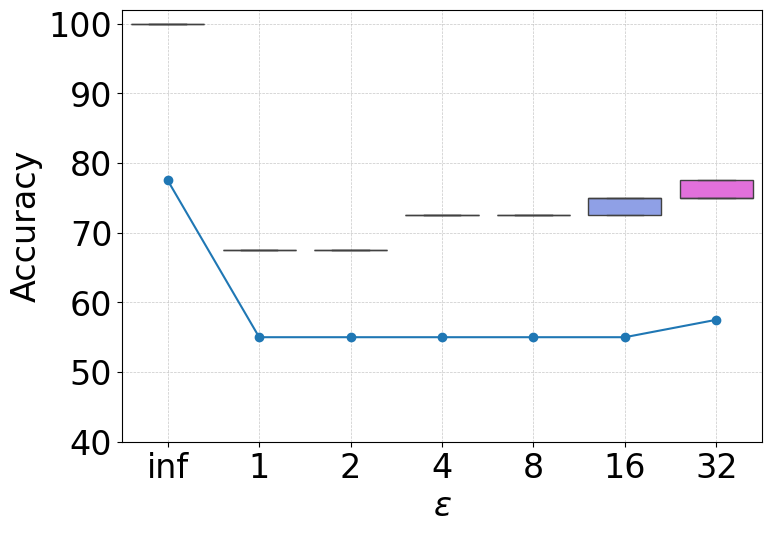

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)


Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_6_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


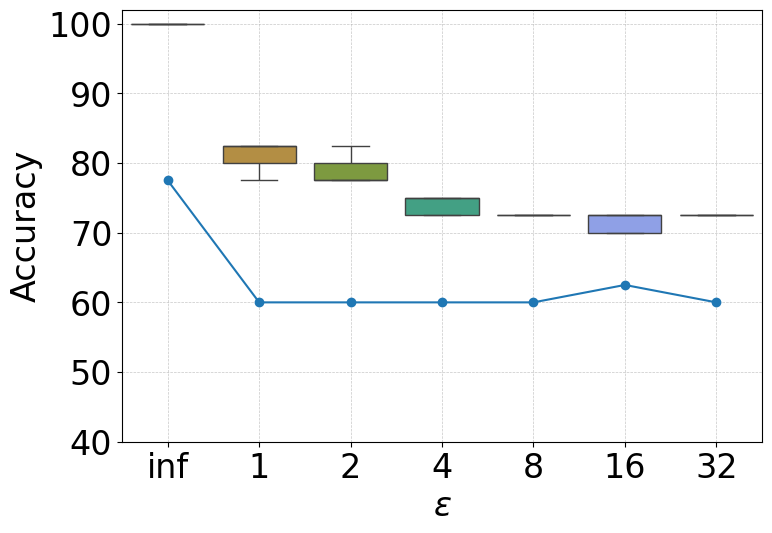

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_7_top_5_acc.csv


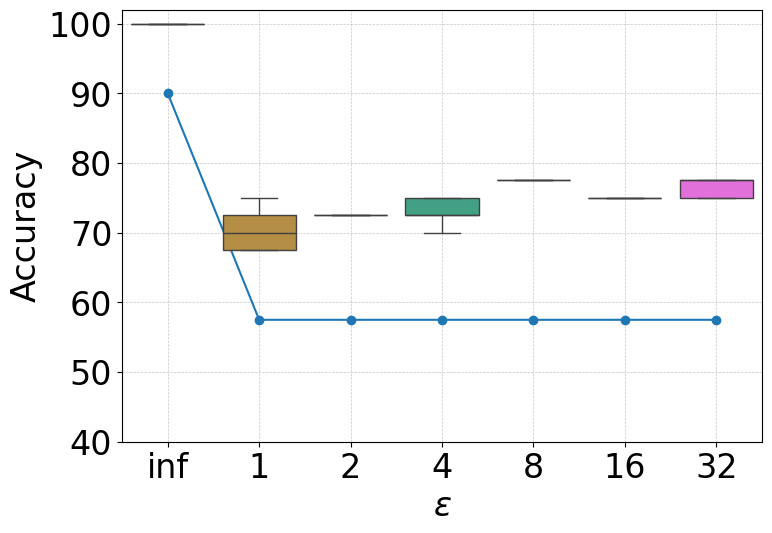

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_8_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


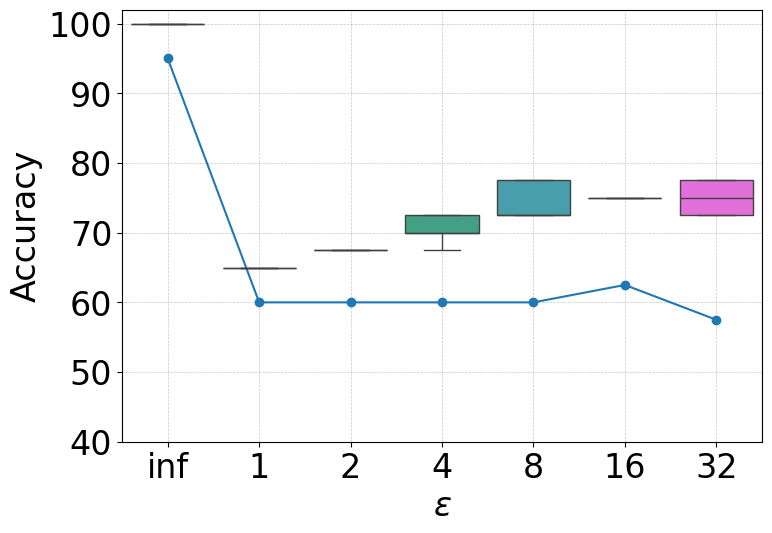

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_9_top_5_acc.csv


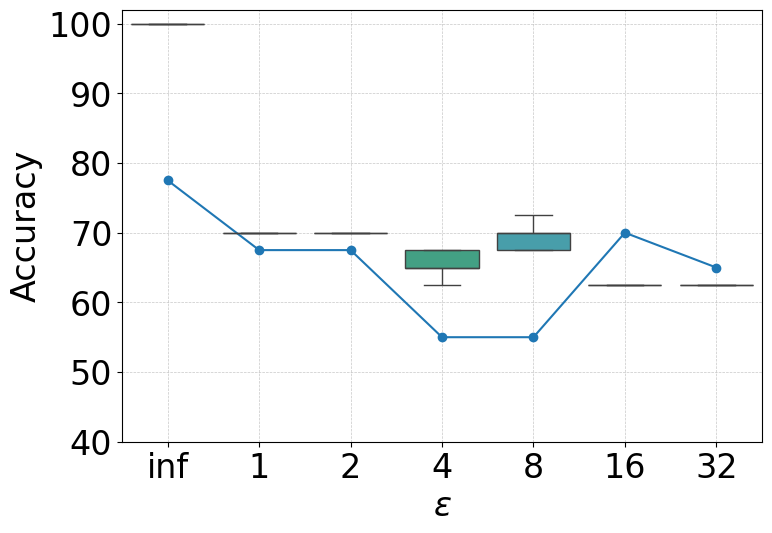

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_10_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


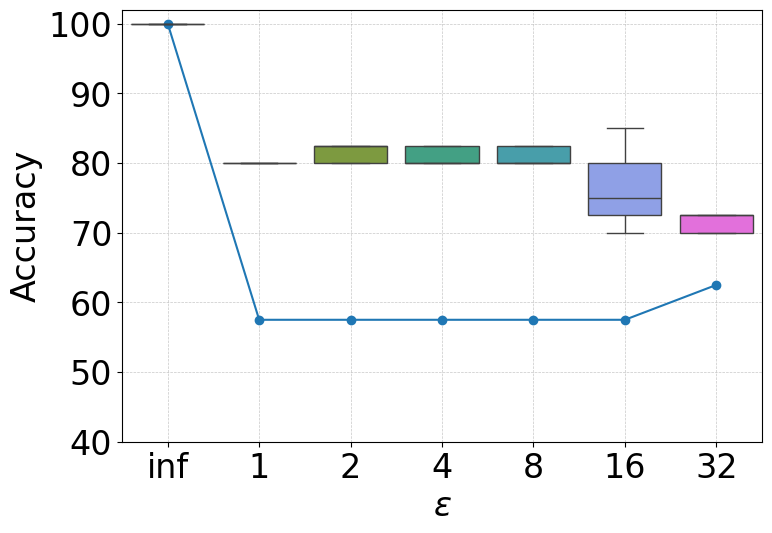

Data used for the plot are saved to saved/caribou_chains2_epsilon_hops_15_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


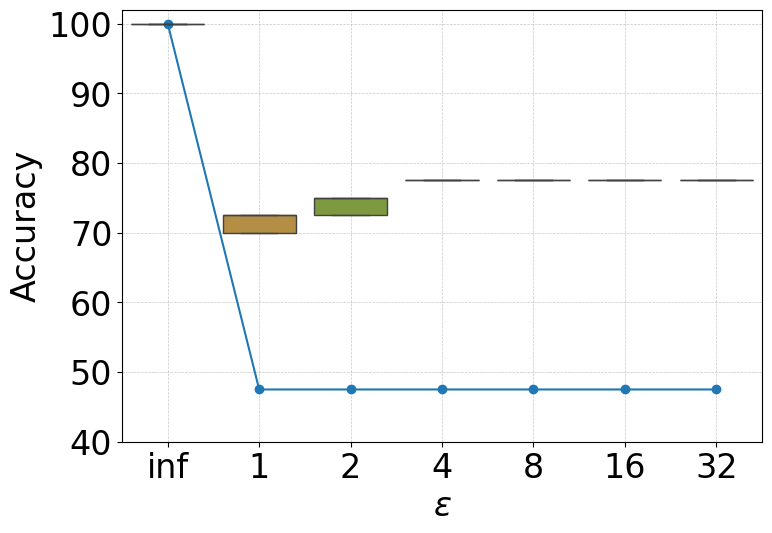

In [ ]:
exp_num = 2
k = 5
get_caribou_results('hops', 'epsilon', 'chains', exp_num, k, dpi=100, font_size=24)
get_caribou_results('epsilon', 'hops', 'chains', exp_num, k, dpi=100, font_size=24)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
def extract_caribou_results(group="epsilon", dataset='chains', exp_num=1, k='all'):
    experiments = []
    gap_experiments = []
    for i in range(7):
        if i == 6:
            file_path = f'output_eps_hop/caribou_{dataset}{exp_num}_inf.txt'
        else:
            file_path = f'output_eps_hop/caribou_{dataset}{exp_num}_e{2**i}.txt'
        experiments += extract_experiments(file_path)
    experiments_df = pd.DataFrame(experiments)
    experiments_df[group] = pd.to_numeric(experiments_df[group], errors='coerce')
    experiments_df[group].fillna(-1, inplace=True)
    experiments_df['max_accuracy'] = pd.to_numeric(experiments_df['max_accuracy'], errors='coerce')
    experiments_df.sort_values(by=[group], inplace=True)

    gap_experiments += extract_experiments(f'output_eps_hop/gap_{dataset}{exp_num}_inf.txt')
    gap_experiments += extract_experiments(f'output_eps_hop/gap_{dataset}{exp_num}_e.txt')


    gap_experiments_df = pd.DataFrame(gap_experiments)
    gap_experiments_df[group] = pd.to_numeric(gap_experiments_df[group], errors='coerce')
    gap_experiments_df[group].fillna(-1, inplace=True)
    gap_experiments_df['max_accuracy'] = pd.to_numeric(gap_experiments_df['max_accuracy'], errors='coerce')
    gap_experiments_df.sort_values(by=[group], inplace=True)

    # print(key)
    
    plot_df = experiments_df
    plot_gap_df = gap_experiments_df

    if k != 'all':
        plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
        plot_gap_df = plot_gap_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
    plot_df['avg_accuracy'] = 0
    for key in pd.unique(plot_df[group]):
        plot_df.loc[plot_df[group] == key, 'avg_accuracy'] = plot_df[plot_df[group] == key]['max_accuracy'].mean()
        plot_gap_df.loc[plot_gap_df[group] == key, 'avg_accuracy'] = plot_gap_df[plot_gap_df[group] == key]['max_accuracy'].mean()
    plot_df.to_csv(f'saved/extract_caribou_{dataset}{exp_num}_{group}_top_{k}_acc.csv', index=False)
    print(f'Data are saved to saved/extract_caribou_{dataset}{exp_num}_{group}_top_{k}_acc.csv')
    plot_gap_df.to_csv(f'saved/extract_gap_{dataset}{exp_num}_{group}_top_{k}_acc.csv', index=False)
    print(f'Data are saved to saved/extract_gap_{dataset}{exp_num}_{group}_top_{k}_acc.csv')


In [ ]:
k = 3
extract_caribou_results(group="epsilon", dataset='chains', exp_num=1, k=3)
extract_caribou_results(group="epsilon", dataset='chains', exp_num=2, k=3)
extract_caribou_results(group="epsilon", dataset='chains', exp_num=3, k=3)
extract_caribou_results(group="epsilon", dataset='computers', exp_num='', k=3)

/tmp/ipykernel_1084565/3700545918.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/3700545918.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Data are saved to saved/extract_caribou_chains1_epsilon_top_3_acc.csv
Data are saved to saved/extract_gap_chains1_epsilon_top_3_acc.csv


/tmp/ipykernel_1084565/3700545918.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/3700545918.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Data are saved to saved/extract_caribou_chains2_epsilon_top_3_acc.csv
Data are saved to saved/extract_gap_chains2_epsilon_top_3_acc.csv


/tmp/ipykernel_1084565/3700545918.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/3700545918.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Data are saved to saved/extract_caribou_chains3_epsilon_top_3_acc.csv
Data are saved to saved/extract_gap_chains3_epsilon_top_3_acc.csv
Data are saved to saved/extract_caribou_computers_epsilon_top_3_acc.csv
Data are saved to saved/extract_gap_computers_epsilon_top_3_acc.csv


/tmp/ipykernel_1084565/3700545918.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/3700545918.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

/tmp/ipykernel_1084565/221220161.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/221220161.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_-1.0_top_5_acc.csv


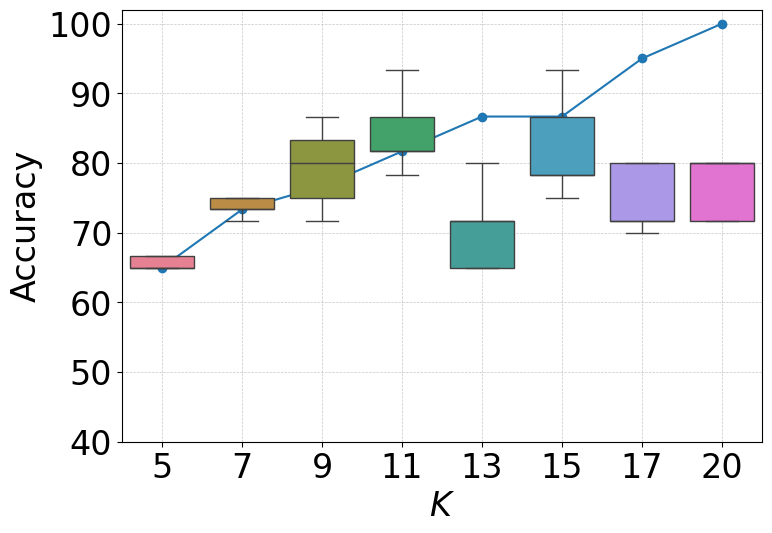

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_1.0_top_5_acc.csv


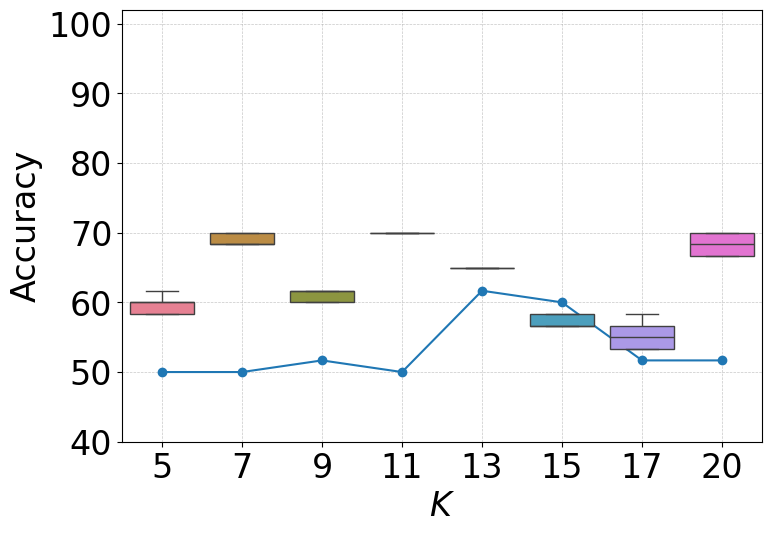

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_2.0_top_5_acc.csv


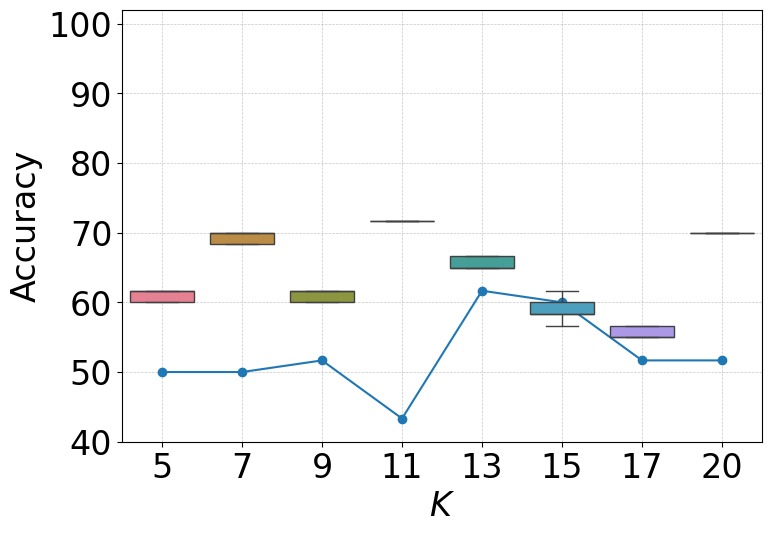

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_4.0_top_5_acc.csv


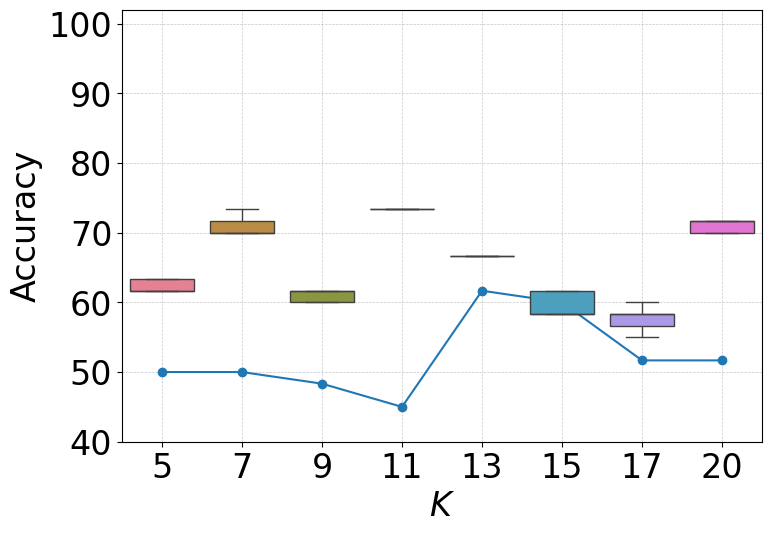

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_8.0_top_5_acc.csv


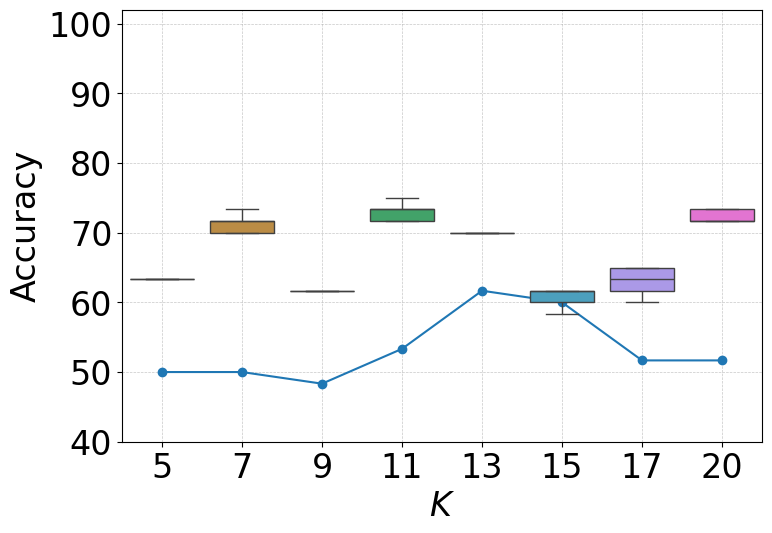

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_16.0_top_5_acc.csv


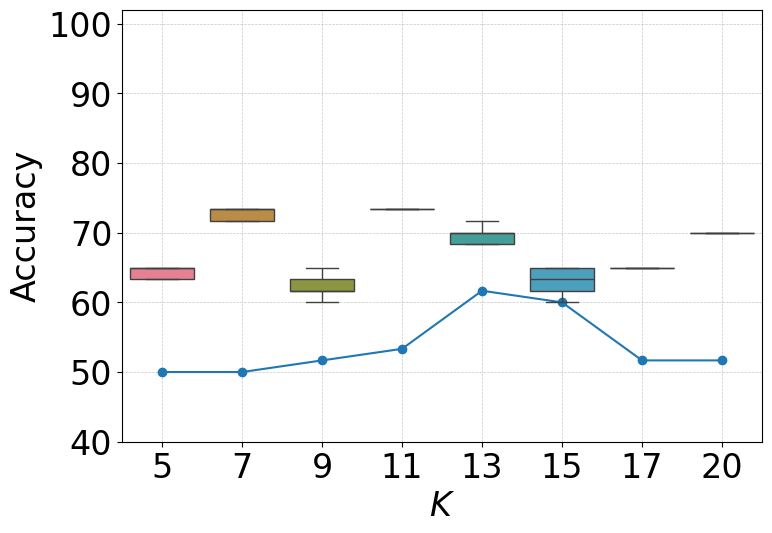

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_hops_epsilon_32.0_top_5_acc.csv


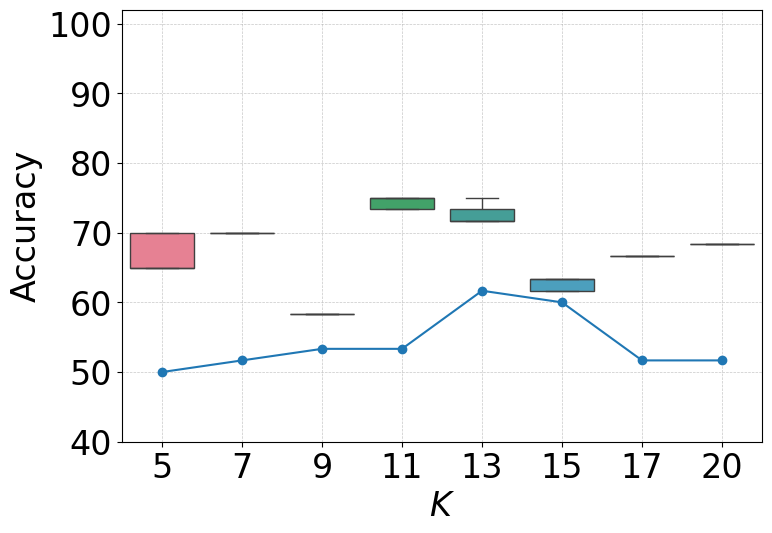

/tmp/ipykernel_1084565/221220161.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  experiments_df[group].fillna(-1, inplace=True)
/tmp/ipykernel_1084565/221220161.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_5_top_5_acc.csv


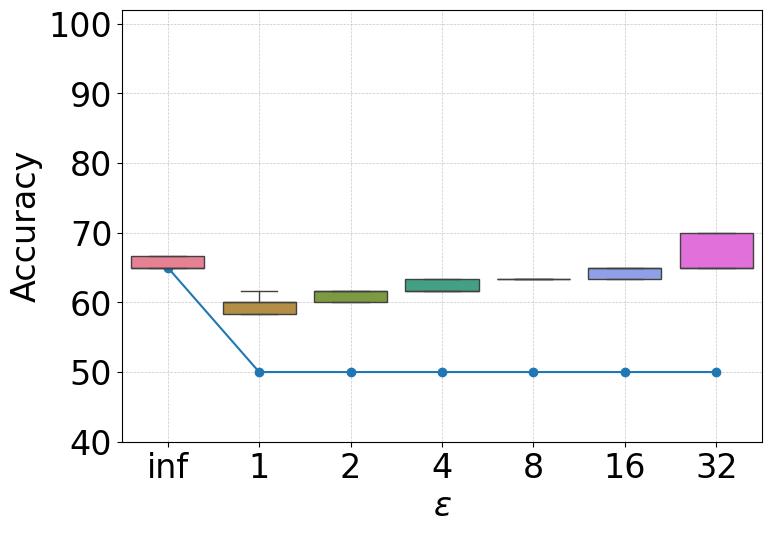

Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_7_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


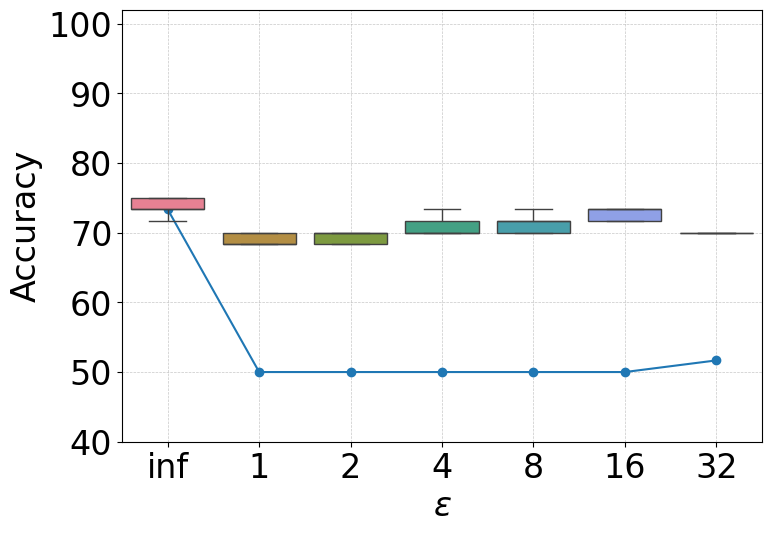

Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_9_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


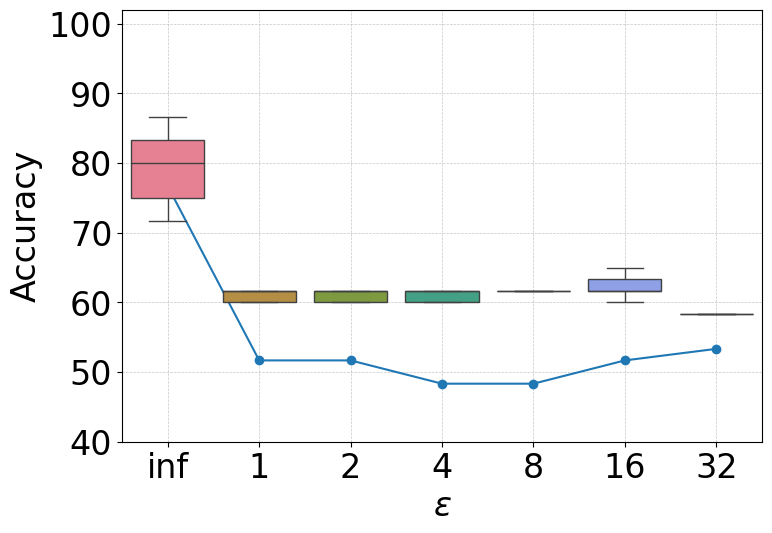

Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_11_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


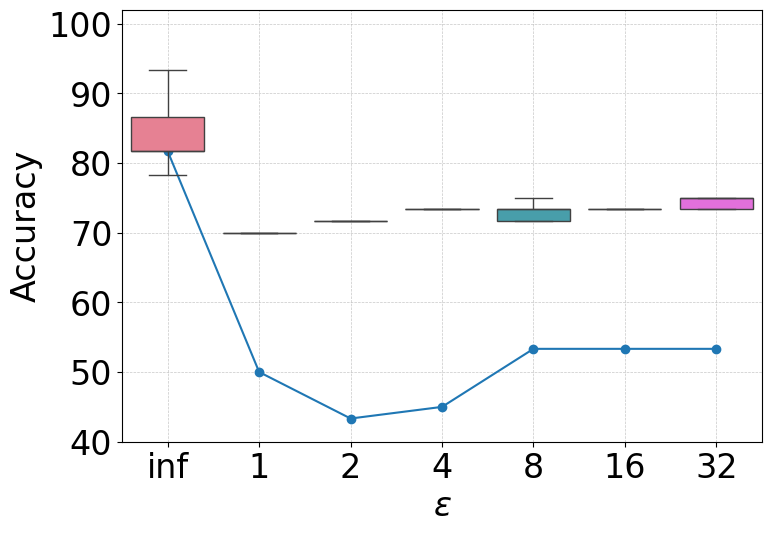

Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_13_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


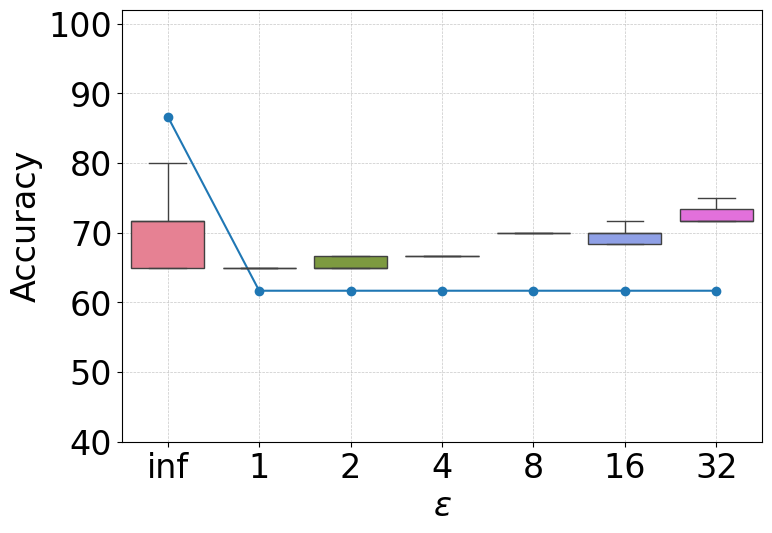

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)


Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_15_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


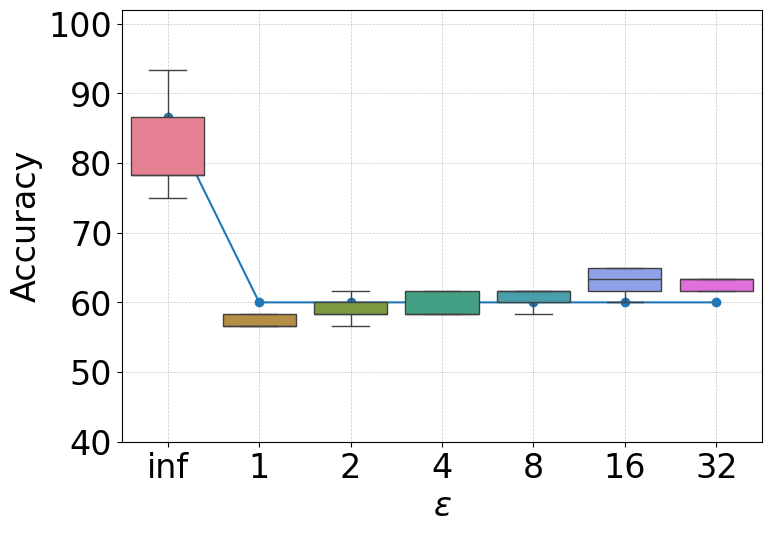

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)


Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_17_top_5_acc.csv


/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


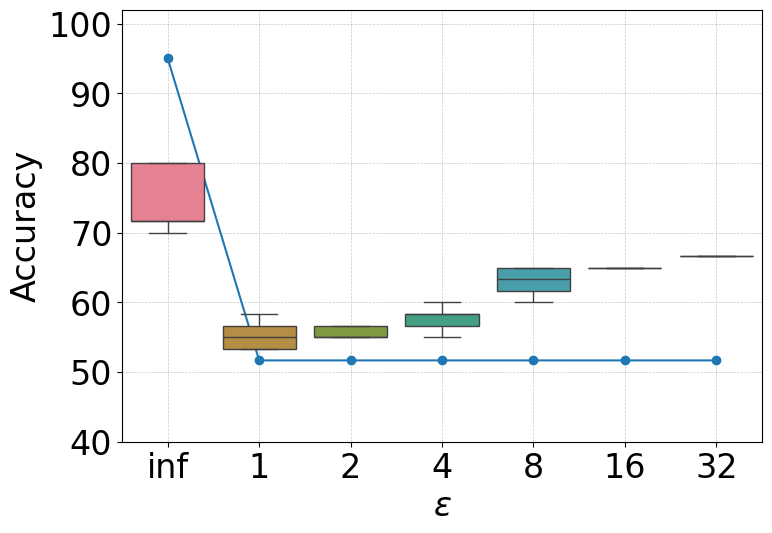

/tmp/ipykernel_1084565/221220161.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby(group).apply(lambda x: x.nlargest(k, 'max_accuracy')).reset_index(drop=True)
/tmp/ipykernel_1084565/221220161.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group, y='max_accuracy', data=plot_df, showfliers=False, palette='husl')


Data used for the plot are saved to saved/caribou_chains3_epsilon_hops_20_top_5_acc.csv


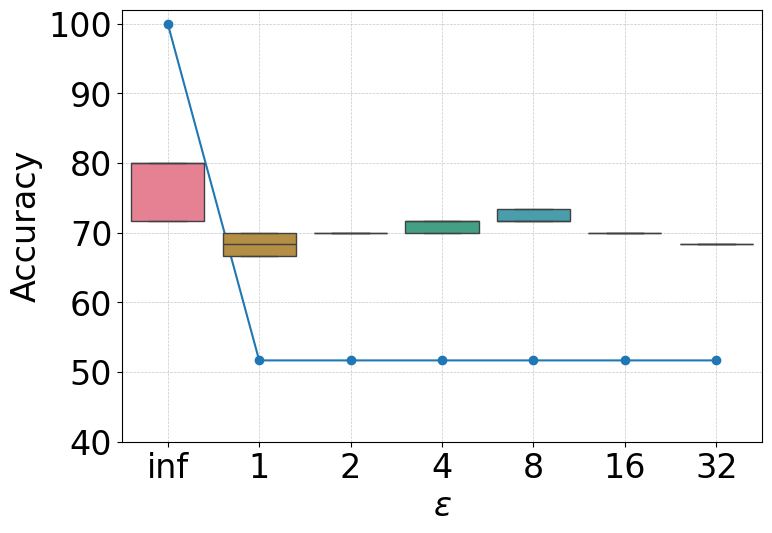

In [ ]:
exp_num = 3
k = 5
get_caribou_results('hops', 'epsilon', 'chains', exp_num, k, dpi=100, font_size=24)
get_caribou_results('epsilon', 'hops', 'chains', exp_num, k, dpi=100, font_size=24)